In [1]:
import os, sys, inspect, io

cmd_folder = os.path.realpath(
    os.path.dirname(
        os.path.abspath(os.path.split(inspect.getfile( inspect.currentframe() ))[0])))

if cmd_folder not in sys.path:
    sys.path.insert(0, cmd_folder)
    
from transitions import *
from transitions.extensions import GraphMachine
from IPython.display import Image, display, display_png

class Matter(object):
    def is_valid(self):
        return True
    
    def is_not_valid(self):
        return False
    
    def is_also_valid(self):
        return True
    
    # graph object is created by the machine
    def show_graph(self, **kwargs):
        stream = io.BytesIO()
        self.get_graph(**kwargs).draw(stream, prog='dot', format='png')
        display(Image(stream.getvalue())) 

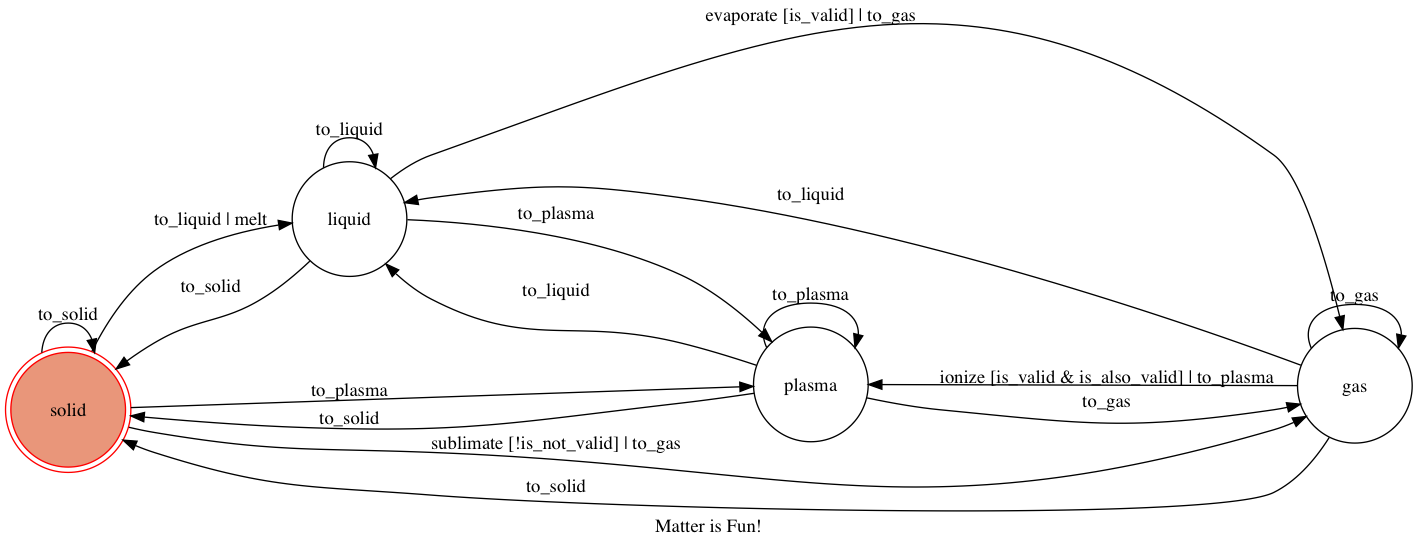

In [2]:
transitions = [
    { 'trigger': 'melt', 'source': 'solid', 'dest': 'liquid' },
    { 'trigger': 'evaporate', 'source': 'liquid', 'dest': 'gas', 'conditions':'is_valid' },
    { 'trigger': 'sublimate', 'source': 'solid', 'dest': 'gas', 'unless':'is_not_valid' },
    { 'trigger': 'ionize', 'source': 'gas', 'dest': 'plasma', 
      'conditions':['is_valid','is_also_valid'] }
]
states=['solid', 'liquid', 'gas', 'plasma']

model = Matter()
machine = GraphMachine(model=model, 
                       states=states, 
                       transitions=transitions,
                       initial='solid',
                       show_auto_transitions=True, # default value is False
                       title="Matter is Fun!",
                       show_conditions=True)
model.show_graph()

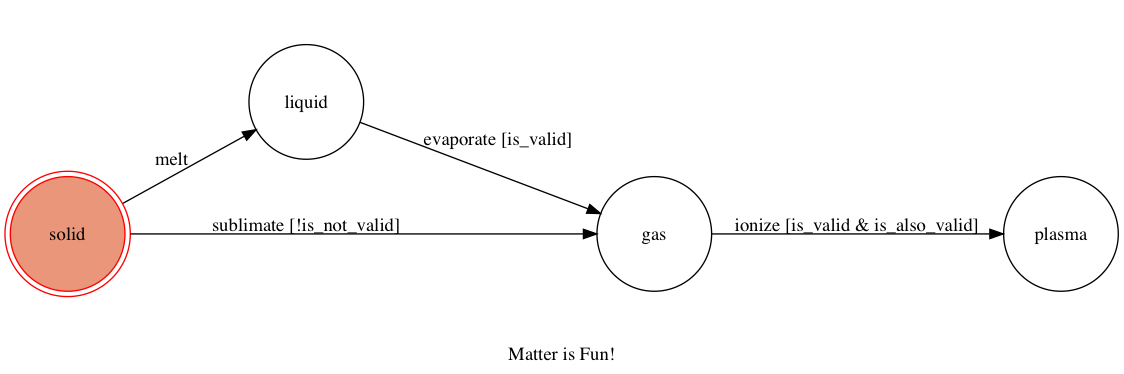

In [3]:
machine.show_auto_transitions = False # hide auto transitions
model.show_graph(force_new=True) # rerender graph

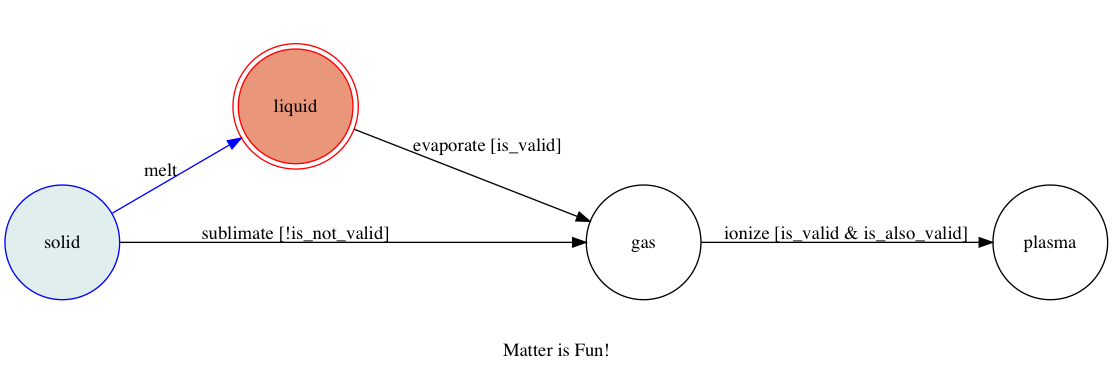

In [4]:
model.melt()
model.show_graph()

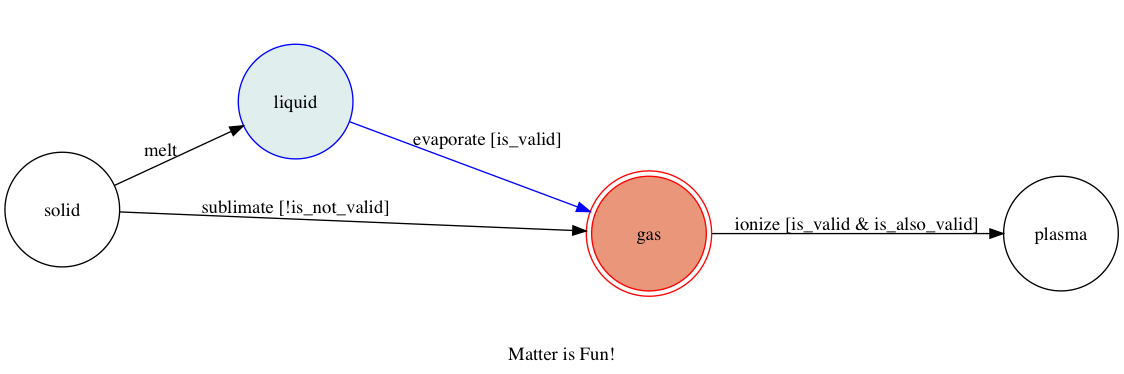

In [5]:
model.evaporate()
model.show_graph()

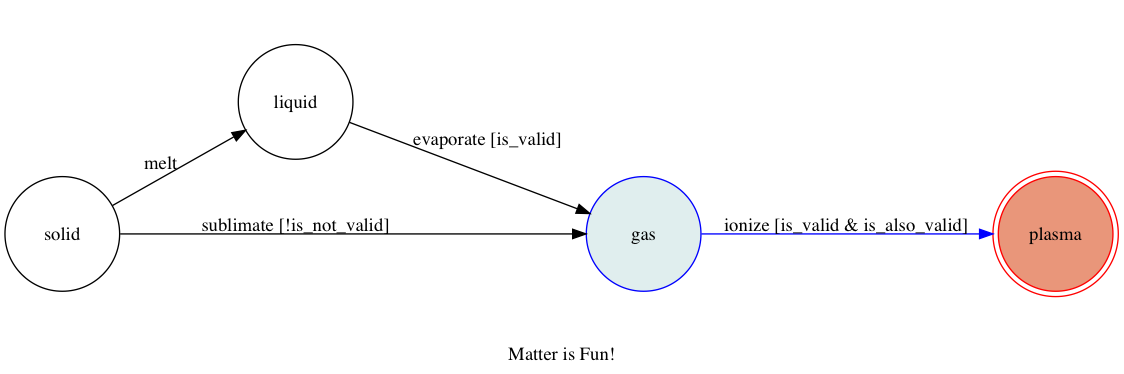

In [6]:
model.ionize()
model.show_graph()

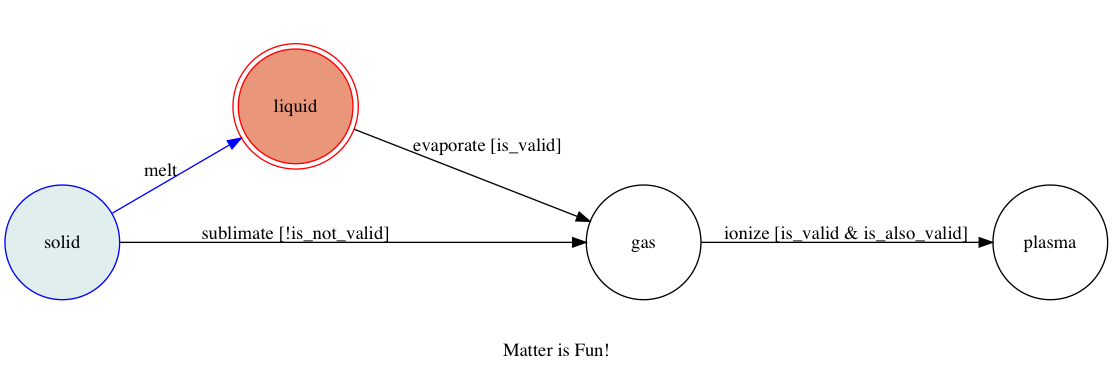

In [7]:
# multimodel test
model1 = Matter()
model2 = Matter()
machine = GraphMachine(model=[model1, model2], 
                       states=states, 
                       transitions=transitions, 
                       initial='solid', 
                       title="Matter is Fun!",
                       show_conditions=True)
model1.melt()
model1.show_graph()

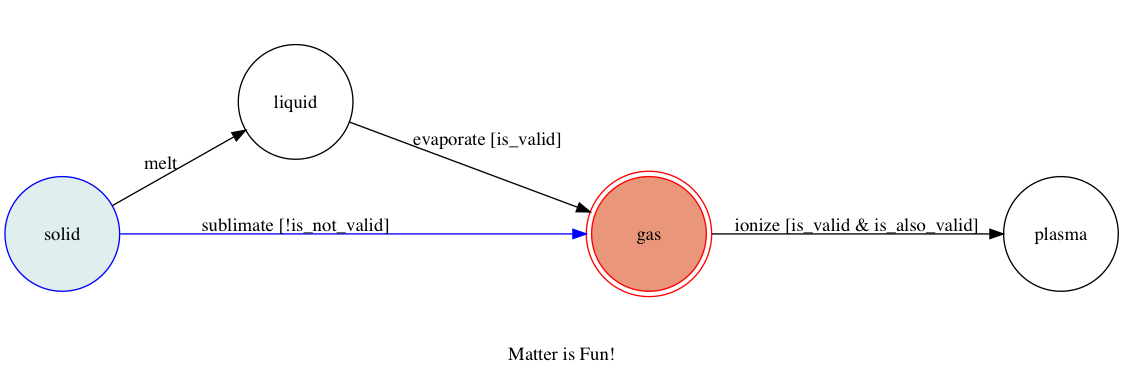

In [8]:
model2.sublimate()
model2.show_graph()

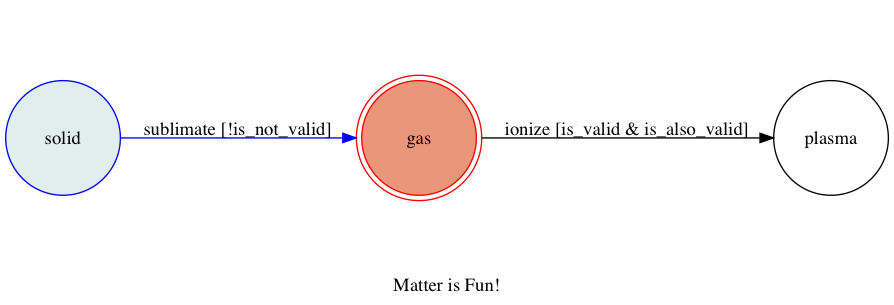

In [9]:
# show only region of interest which is previous state, active state and all reachable states
model2.show_graph(show_roi=True)